# Introduction

In [10]:
using Plots; gr()
using DifferentialEquations
using Base.Threads; println(Threads.nthreads(), " threads available.")
using ProgressMeter
using LinearAlgebra
using CSV

8 threads available.


$$ l = \frac{l_2}{l_1}
    \qquad
    m = \frac{m_2}{m_1}
    \qquad
    \tau = \sqrt{\frac{g}{l_1}} t $$

In [2]:
struct Parameters
    m::Float64
    L::Float64
end

In [3]:
struct State <: AbstractVector{Float64}
    θ1::Float64; θ2::Float64
    ω1::Float64; ω2::Float64
end

Base.size(A::State) = (4,)
function Base.getindex(A::State, i::Int)
    if     i == 1; return A.θ1
    elseif i == 2; return A.θ2
    elseif i == 3; return A.ω1
    elseif i == 4; return A.ω2
    else; throw(BoundsError(A,i))
    end
end
Base.eltype(::Type{State}) = Float64
Base.:+(A::State, B::State) = State(A.θ1+B.θ1, A.θ2+B.θ2, A.ω1+B.ω1, A.ω2+B.ω2)
Base.:-(A::State, B::State) = State(A.θ1-B.θ1, A.θ2-B.θ2, A.ω1-B.ω1, A.ω2-B.ω2)

In [4]:
struct StateVector <: AbstractVector{State}
    arr::Vector{State}
end

Base.size(A::AbstractVector{State}) = (length(A.arr),)
Base.getindex(A::AbstractVector{State}, i::Int) = A.arr[i]
Base.eltype(::Type{AbstractVector{State}}) = State

In [5]:
struct PhasePath <: AbstractVector{State}
    arr::Vector{State}
    t::Vector{Float64}
end

In [6]:
struct PoincareSection <: AbstractVector{State}
    arr::Vector{State}
    E::Float64
end

## Used parameters for numerical calculations

In [7]:
const std_tfinal = 1000.;
const std_δZ_0 = State(1e-6, 1e-6, 1e-6, 1e-6)
const div = (16, 8, 4)
const integrator_atol = 1e-8;
const integrator_reltol = 1e-8;

# Motion equation

$$ \mathcal{T}_d = \frac{1}{2} m_1 l_1^2 \dot{\theta}_1^2 + \frac{1}{2} m_2 [l_1^2 \dot{\theta}_1^2 + l_2^2 \dot{\theta}_2^2 + 2 l_1 l_2 \dot{\theta}_1 \dot{\theta}_2 \cos{(\theta_1-\theta_2)}] $$

$$ \mathcal{V}_d = -(m_1 + m_2) g l_1 \cos{\theta_1} - m_2 g l_2 \cos{\theta_2} $$

$$ \mathcal{L}_d = \frac{1}{2} m_1 l_1^2 \dot{\theta}_1^2 + \frac{1}{2} m_2 [l_1^2 \dot{\theta}_1^2 + l_2^2 \dot{\theta}_2^2 + 2 l_1 l_2 \dot{\theta}_1 \dot{\theta}_2 \cos{(\theta_1-\theta_2)}] +(m_1 + m_2) g l_1 \cos{\theta_1} + m_2 g l_2 \cos{\theta_2} $$

$$ \frac{\text{d}}{\text{d}t} \left( \frac{\partial \mathcal{L}_d}{\partial \dot{\theta}_i} \right) - \frac{\partial \mathcal{L}_d}{\partial \theta_i} = 0 \quad , \quad (i = 1, \ 2) $$

$$ \begin{cases}
\begin{aligned}
    0 =  & l_1 (m_1+m_2) \ddot{\theta}_1 + l_2 m_2 [\cos{(\theta_1-\theta_2)} \ddot{\theta}_2 + \sin{(\theta_1-\theta_2)} \dot{\theta}_2^2] + g (m_1+m_2) \sin{\theta_1} \\
    0 = & l_2 \ddot{\theta}_2 + l_1 [\cos{(\theta_1-\theta_2)} \ddot{\theta}_1 - \sin{(\theta_1-\theta_2)} \dot{\theta}_1^2]  + g \sin{\theta}_2 = 0
\end{aligned}
\end{cases} $$

In [8]:
function doublependulum(
        u::Array{Float64, 1},
        p::Parameters,
        t::Float64)
    
    θ1 = u[1]; ω1 = u[3];
    θ2 = u[2]; ω2 = u[4];
    
    m = p.m
    L = p.L
    
    ω = [ω1; ω2]
    
    M = [1+m               m*L*cos(θ1-θ2)
         m*L*cos(θ1-θ2)    m*L^2         ]
    
    f = [-m*L*sin(θ1-θ2)*ω2^2-(1+m)*sin(θ1)
         m*L*sin(θ1-θ2)*ω1^2-m*L*sin(θ2)  ]
    
    dθ = ω
    dω = M\f
    
    du = [dθ; dω]
    
    return du
end

doublependulum (generic function with 1 method)

In [ ]:
# Couldn't get this one to work

function doublependulum!(
    u::Array{Float64, 1},
    p::Parameters,
    t::Float64)

θ1 = u[1]; ω1 = u[3];
θ2 = u[2]; ω2 = u[4];

m = p.m
L = p.L

ω = [ω1; ω2]

M = [1+m               m*L*cos(θ1-θ2)
     m*L*cos(θ1-θ2)    m*L^2         ]

f = [-m*L*sin(θ1-θ2)*ω2^2-(1+m)*sin(θ1)
     m*L*sin(θ1-θ2)*ω1^2-m*L*sin(θ2)  ]

dθ = ω
dω = M\f

du = [dθ; dω]

return du
end

# Sectioning by the energy state

In [9]:
function energy(p::Parameters, state::State)
    m = p.m
    L = p.L
    
    θ1 = state.θ1; ω1 = state.ω1
    θ2 = state.θ2; ω2 = state.ω2
    
    T = (1/2)*ω1^2 +(1/2)*m*(ω1^2 +L^2*ω2^2 +2*L*ω1*ω2*cos(θ1-θ2))
    V = -(1+m)*cos(θ1) -m*L*cos(θ2)
    
    return T+V
end

energy (generic function with 1 method)

In [11]:
function minenergy(p::Parameters)
    m = p.m
    L = p.L
    
    a1 = -(1+m)
    a2 = -m*L
    
    return a1+a2
end

minenergy (generic function with 1 method)

$$ \mathcal{E} = \frac{1}{2} {\theta_1'}^2 + \frac{1}{2} m [{\theta_1'}^2 + l^2 {\theta_2'}^2 + 2 l \theta_1' \theta_2'\cos{(\theta_1-\theta_2)}] -(1 + m) \cos{\theta_1} - m l \cos{\theta_2} $$

$$ \mathcal{E}_{\theta_1} =  a_1 \cos{\theta_1} \qquad a_1 = -(1+m) $$

$$ \mathcal{E}_{\theta_2} =  a_2 \cos{\theta_2} \qquad a_2 = -m l $$

$$ \mathcal{E}_{\dot{\theta}_1} =  a_3 \dot{\theta}_1^2 \qquad a_3 = \frac{1}{2} (1+m) $$

$$ \mathcal{E}_{\dot{\theta}_2} =  a_4 \dot{\theta}_2^2 \qquad a_4 = \frac{1}{2} m l^2 $$

$$ \mathcal{E}_{rel} =  a_5 \dot{\theta}_1 \dot{\theta}_2 \cos{(\theta_1-\theta_2)} \qquad a_5 = m l $$

$$ \implies \mathcal{E} = \mathcal{E}_{\theta_1} + \mathcal{E}_{\theta_2} + \mathcal{E}_{\dot{\theta}_1} + \mathcal{E}_{\dot{\theta}_2} + \mathcal{E}_{rel} $$

In the inner loop cicle, we shal be able to solve the following expression for $\theta_2$:

$$ a_4 \dot{\theta}_2^2 + a_5 \dot{\theta}_1 \dot{\theta}_2 \cos{(\theta_1-\theta_2)} - \mathcal{E}_{lef} = 0 $$

Based on that, we can compute the derivate of the function in respect to $\theta_2$.

, where $\mathcal{E}_{lef} = \mathcal{E} - \mathcal{E}_{\theta_1} - \mathcal{E}_{\theta_2} - \mathcal{E}_{\dot{\theta}_1}$ and $\theta_1$, $\theta_2$, 

In [11]:
function energy_section(
        p::Parameters,
        E::Float64;
        div::Tuple{Int, Int, Int} = div)::StateVector
    
    m = p.m
    L = p.L
    
    a1 = -(1+m)
    a2 = -m*L
    a3 = (1/2)*(1+m)
    a4 = (1/2)*m*L^2
    a5 = m*L
    
    state_vec = Vector{State}(undef, 2*div[1]*div[2]*div[3])
    
    if E <= a1+a2
        @error "There will be no states with this energy, try one larger than $(a1+a2)"
        return StateVector(state_vec)
    end
    
    # Calculating θ1max
    θ1max = E > -a1 ?  Float64(π) : acos(E/a1)
    
    i = 0
    j = 0
    for θ1_0 in LinRange(0, θ1max, div[1])
        # θ1 defined
        Eθ1_0 = a1*cos(θ1_0)
        Elef = E - Eθ1_0
        θ2max = Elef > -a2 ?  Float64(π) : 0.99*acos(Elef/a2)
        
        for θ2_0 in LinRange(0, θ2max, div[2])
            # θ1 and θ2 defined
            Eθ2_0 = a2*cos(θ2_0)
            Elef = E - Eθ1_0 - Eθ2_0
            ω1max = 0.99*sqrt(Elef/a3)
            
            for ω1_0 in LinRange(0, ω1max, div[3])
                # θ1, θ2 and ω1 defined
                Eω1_0 = a3*ω1_0^2
                Elef = E - Eθ1_0 - Eθ2_0 - Eω1_0
                
                try
                    A = a4
                    B = a5*ω1_0*cos(θ1_0-θ2_0)
                    C = -Elef
                    Δ = B^2 - 4*A*C
                    ω2_01 = (-B+sqrt(Δ))/(2*A)
                    ω2_02 = (-B-sqrt(Δ))/(2*A)
                    
                    state1 = State(θ1_0, θ2_0, ω1_0, ω2_01)
                    state2 = State(θ1_0, θ2_0, ω1_0, ω2_02)
                
                    i += 1
                    state_vec[i] = state1
                    i += 1
                    state_vec[i] = state2
                catch err
                    j += 2
                    print(Δ)
                end
                
            end
        end
    end
    
    state_vec = state_vec[1:i]
                
    return StateVector(state_vec)
end

energy_section (generic function with 1 method)

# Poincaré Section

In [12]:
function PhasePath(
        p::Parameters,
        init_state::State;
        tfinal::Float64 = std_tfinal)::PhasePath

    u0 = [init_state.θ1, init_state.θ2, init_state.ω1, init_state.ω2]
    tspan = (0.0, tfinal)
    
    problem = ODEProblem(doublependulum, u0, tspan, p, reltol=integrator_reltol, atol=integrator_atol)
    sol = solve(problem)
    
    θ1arr = sol[1,:]; θ2arr = sol[2,:]
    ω1arr = sol[3,:]; ω2arr = sol[4,:]
    t = sol.t
    
    # Let's construct the object now
    path = Vector{State}(undef, length(θ1arr))
    
    for i in 1:length(θ1arr)
        path[i] = State(θ1arr[i], θ2arr[i], ω1arr[i], ω2arr[i])
    end
    
    return PhasePath(path, t)
end

PhasePath

In [13]:
function PoincareSection(
        p::Parameters,
        E::Float64;
        div::Tuple{Int, Int, Int} = div,
        tfinal::Float64 = std_tfinal)::PoincareSection
    
    state_arr = energy_section(p, E, div = div)
    
    size = length(state_arr)
    space = Array{PhasePath, 1}(undef, 0)
    
    prog = Progress(size)
    @threads for init_state in state_arr
        push!(space, PhasePath(p, init_state, tfinal=tfinal))
        next!(prog)
    end
    
    section = Vector{State}(undef, 0)
    for path in space
        for i in 1:length(path)-1
            θ1_1 = rem2pi(path[i].θ1, RoundNearest)
            θ2_1 = rem2pi(path[i].θ2, RoundNearest)
            ω1_1 = path[i].ω1
            ω1_1 = path[i].ω1
            state1 = State(θ1_1, θ2_1, ω1_1, ω1_1)
            
            θ1_2 = rem2pi(path[i+1].θ1, RoundNearest)
            θ2_2 = rem2pi(path[i+1].θ2, RoundNearest)
            ω1_2 = path[i+1].ω1
            ω1_2 = path[i+1].ω1
            state2 = State(θ1_2, θ2_2, ω1_2, ω1_2)
            if θ1_1 <= 0. && θ1_2 >= 0.
                state = State(((state1*state1.θ1-state2*state2.θ1)/(state2.θ1-state1.θ1))...)
                push!(section, state)
            end
        end
    end
    
    return PoincareSection(section, E)
end

PoincareSection

In [14]:
function PoincareSection(
        p::Parameters,
        E::Float64;
        div::Tuple{Int, Int, Int} = div,
        tfinal::Float64 = std_tfinal)::PoincareSection
    
    state_arr = energy_section(p, E, div = div)
    
    size = length(state_arr)
    space = Array{PhasePath, 1}(undef, 0)
    
    prog = Progress(size)
    @threads for init_state in state_arr
        push!(space, PhasePath(p, init_state, tfinal=tfinal))
        next!(prog)
    end
    
    section = Vector{State}(undef, 0)
    for path in space
        for i in 1:length(path)-1
            if path[i].θ1 <= 0. && path[i+1].θ1 >= 0.
                state = State(((path[i]*path[i+1].θ1-path[i+1]*path[i].θ1)/(path[i+1].θ1-path[i].θ1))...)
                push!(section, state)
            end
        end
    end
    
    return PoincareSection(section, E)
end

PoincareSection

In [15]:
function lyapunov(
        p::Parameters,
        init_state::State;
        δZ_0::State = std_δZ_0,
        tfinal::Float64 = std_tfinal)::Tuple{Float64,Float64}
    
    init_state1 = init_state
    init_state2 = init_state1 + δZ_0
    
    λ_max = 0.
    t_max = 0.
        
    u0_1 = [init_state1.θ1, init_state1.θ2, init_state1.ω1, init_state1.ω2]
    u0_2 = [init_state2.θ1, init_state2.θ2, init_state2.ω1, init_state2.ω2]
    tspan = (0.0, tfinal)
    
    problem1 = ODEProblem(doublependulum!, u0_1, tspan, p, reltol=integrator_reltol, atol=integrator_atol)
    problem2 = ODEProblem(doublependulum!, u0_2, tspan, p, reltol=integrator_reltol, atol=integrator_atol)
        
    sol1 = solve(problem1, alg_hints=[:stiff])
    sol2 = solve(problem2, alg_hints=[:stiff])
    
    
    h1 = 0.001
    h2 = 0.00001
    
    for t in h1:h1:tfinal
        δZ_f = sol1(t)-sol2(t)
        λ = (1/t)*log(δZ_f/δZ_0)
        
        if λ > λ_max
            λ_max = λ
            t_max = t
        end
    end
    
    for t in t_max-(h1/2):h2:t_max+(h1/2)
        δZ_f = sol1(t)-sol2(t)
        λ = (1/t)*log(norm(δZ_f)/norm(δZ_0))
        
        if λ > λ_max
            λ_max = λ
            t_max = t
        end
    end

    return (λ_max, t_max)
end

lyapunov (generic function with 1 method)

# Correlation Dimension

$$ C(r) = \frac{1}{N^2} \sum_i \sum_j H(r - |x_i - x_j|) $$
$$ d = \frac{\log (C(r))}{\log(r)} $$

In [16]:
function correlationdimension(
        section::PoincareSection;
        r::Float64 = 1e-10)
    
    N = size(section)[1]
    n = 0
    
    for x_i in section, x_j in section
        x = x_i - x_j
        dist = sqrt(x.θ2^2 + x.ω2^2)
        if dist <= r
            n += 1
        end
    end
    
    C = n/N^2
    d = log(C)/log(r)
    
    return d
end

correlationdimension (generic function with 1 method)

According to https://mathworld.wolfram.com/CorrelationDimension.html, to estimate tha dimension of an $M$-dimensional system with accuracy $(1-Q)$ requires $N_{min}$ data points

$$ N_{min} \ge \left[ \frac{R (2-Q)}{2 (1-Q)} \right]^M

In [12]:
function nmin(Q::Float64, M::Float64, R::Float64)::Int
    Nmin = ((R*(2-Q)/(2*(1-Q)))^M)
    return Nmin
end

nmin (generic function with 1 method)

## Testing the algorithm

In [ ]:
function buckledbean(
    u::Array{Float64, 1},
    p::Parameters,
    t::Float64)

    
    
end

# Time to flip

Just having some fun trying to replicate a map i found on Wikipedia.

In [17]:
function timetoflip(
        p::Parameters,
        init_state::State;
        tfinal::Float64 = 10000)
    
    u0 = [init_state.θ1, init_state.θ2, init_state.ω1, init_state.ω2]
    tspan = (0.0, 2*tfinal)
   
    problem = ODEProblem(doublependulum, u0, tspan, p)
    
    integrator = init(problem, :auto)
    
    step!(integrator)
    while abs(integrator.u[1]) < 2π || abs(integrator.u[1]) < 2π || integrator.t < tfinal
        step!(integrator)
    end
    
    t0 = integrator.tprev
    t1 = integrator.t
    
    if abs(integrator.u[1]) < 2π
        x0 = integrator.uprev[1]
        x1 = integrator.u[1]
    elseif abs(integrator.u[2]) < 2π
        x0 = integrator.uprev[2]
        x1 = integrator.u[2]
    else
        @error "You should not be seeing this"
    end
    
    t = y0 + (2π-x0)*((y1-y0)/(x1-x0))
    return t
end

timetoflip (generic function with 1 method)

In [18]:
timetoflip(Parameters(1,1), State(1,1,0,0))

LoadError: [91mMethodError: no method matching #timetoflip#9(::Int64, ::typeof(timetoflip), ::Parameters, ::State)[39m
[91m[0mClosest candidates are:[39m
[91m[0m  #timetoflip#9([91m::Float64[39m, ::typeof(timetoflip), ::Parameters, ::State) at In[17]:1[39m

# Ploting

In [19]:
function getθ1arr(path::AbstractVector{State})::Vector{Float64}
    arr = Vector{Float64}(undef, length(path))
    for i in 1:length(path)
        arr[i] = path[i].θ1
    end
    return arr
end

function getθ2arr(path::AbstractVector{State})::Vector{Float64}
    arr = Vector{Float64}(undef, length(path))
    for i in 1:length(path)
        arr[i] = path[i].θ2
    end
    return arr
end

function getω1arr(path::AbstractVector{State})::Vector{Float64}
    arr = Vector{Float64}(undef, length(path))
    for i in 1:length(path)
        arr[i] = path[i].ω1
    end
    return arr
end

function getω2arr(path::AbstractVector{State})::Vector{Float64}
    arr = Vector{Float64}(undef, length(path))
    for i in 1:length(path)
        arr[i] = path[i].ω2
    end
    return arr
end

getω2arr (generic function with 1 method)

In [20]:
function plot(path::PhasePath)
    θ1arr = getθ1arr(path)
    θ2arr = getθ2arr(path)
    ω1arr = getω1arr(path)
    ω2arr = getω2arr(path)
    
    θplot = plot(path.t, [θ1arr θ2arr], title = "Angular positions", label = ["θ1" "θ2"])
    ωplot = plot(path.t, [ω1arr ω2arr], title = "Angular velocities", label = ["ω1" "ω2"])
    
    plot(θplot, ωplot, layout=(2,1), size=(800,600))
end

function plot(section::PoincareSection)
    arrX = getθ2arr(section)
    arrY = getω2arr(section)
    xlabel = "θ2"; ylabel = "ω2"
        
    scatter(arrX, arrY, title = "Section", marker = (1, 1, :black), size=(800,600), xlabel=xlabel, ylabel=ylabel, fmt = :png)
end

plot (generic function with 2 methods)

# Preparating for Hausdorff Dimension

In [21]:
function hausdorff_img(section::PoincareSection,
    file_name::String)
    arrX = getθ2arr(section)
    arrY = getω2arr(section)
    xlabel = "θ2"; ylabel = "ω2"
        
    fig = scatter(arrX, arrY, marker = (0.2, 0.2, :black), markershape = :circle, axis=([], false), background_color = :transparent, foreground_color=:black, legend = false, size=(3000,3000), grid=false, fmt = :png)
    savefig(fig, file_name)
end

hausdorff_img (generic function with 1 method)

# Replicating the sections

## Obtained sections with complete energy sectioning

The arcticle published by Stachoviak uses the following parameters:

In [22]:
m1 = 3.; m2 = 1.
L1 = 2.; L2 = 1.
g = 1.;

p = Parameters(m2/m1, L2/L1)

Parameters(0.3333333333333333, 0.5)

In [23]:
E = [-9. + 0.01
     -7. - 0.01
      7. - 0.01
      9. - 0.01]/(g*m1*L1)

4-element Array{Float64,1}:
 -1.4983333333333333
 -1.1683333333333332
  1.165
  1.4983333333333333

In [24]:
@time section2 = PoincareSection(p, E[2])

Progress: 100%|█████████████████████████████████████████| Time: 0:01:44


104.192123 seconds (1.28 G allocations: 107.514 GiB, 32.94% gc time)


165810-element PoincareSection:
 [0.0, 1.0128614796161817, 0.6313403976555175, -0.36755857076786935]
 [0.0, -1.5117237047893295, 0.39069392380319484, 1.2092587160809194]
 [0.0, 0.625279569843921, 0.7312757153095053, -0.9832433186692296]
 [0.0, -1.2742730122119788, 0.260045978634052, 1.824118233847159]
 [0.0, 0.020404505619095223, 0.8096319314726084, -1.393597115602298]
 [0.0, 1.2970034844565828, 0.27091681320196126, 1.8250441989437594]
 [0.0, -0.5947128937255123, 0.7350434929737989, -1.004533747836708]
 [0.0, 1.5194297467157856, 0.3909207936600269, 1.2308220762411541]
 [0.0, -0.9971573057693456, 0.6368865256771102, -0.40343330624861296]
 [0.0, 1.4449995240295652, 0.4833682749962598, 0.6588167741849696]
 [0.0, -1.3277733677248167, 0.5400448224735838, 0.2967593616271273]
 [0.0, 1.152122066918342, 0.5887991487471096, -0.06665105434618429]
 [0.0, -1.4967064415170301, 0.42641929553909563, 0.9782100112765592]
 ⋮
 [0.0, 2.3914456515794016, 0.22634929259910494, 0.8780068167142019]
 [0.0, 1.179

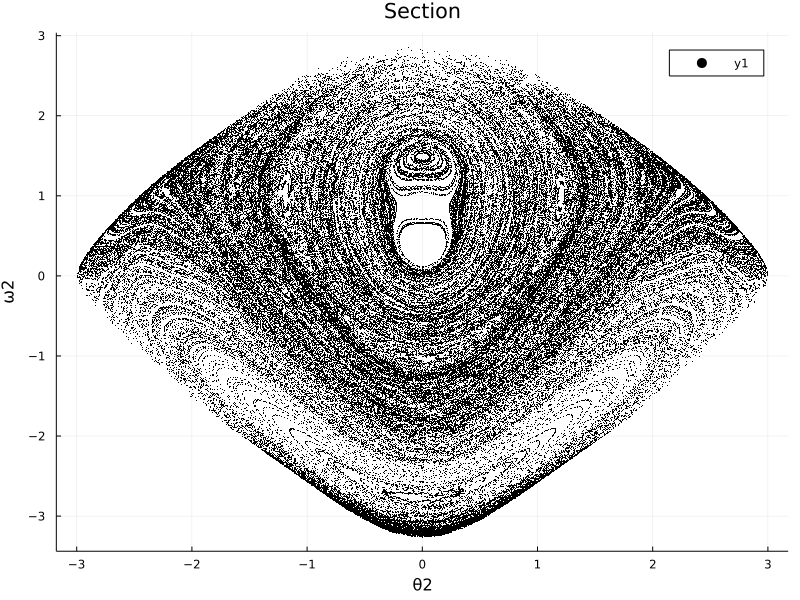

In [25]:
plot(section2)

In [26]:
@time correlationdimension(section2)

 53.878875 seconds


0.5219610719301437

## Section with paper

In [ ]:
unction PoincareSection_paper(
        p::Parameters,
        E::Float64;
        div::Tuple{Int, Int, Int} = div,
        tfinal::Float64 = std_tfinal)::PoincareSection
    
    state_arr = energy_section(p, E, div = div)
    
    size = length(state_arr)
    space = Array{PhasePath, 1}(undef, 0)
    
    prog = Progress(size)
    @threads for init_state in state_arr
        push!(space, PhasePath(p, init_state, tfinal=tfinal))
        next!(prog)
    end
    
    section = Vector{State}(undef, 0)
    for path in space
        for i in 1:length(path)-1
            θ1_1 = rem2pi(path[i].θ1, RoundNearest)
            θ2_1 = rem2pi(path[i].θ2, RoundNearest)
            ω1_1 = path[i].ω1
            ω1_1 = path[i].ω1
            state1 = State(θ1_1, θ2_1, ω1_1, ω1_1)
            
            θ1_2 = rem2pi(path[i+1].θ1, RoundNearest)
            θ2_2 = rem2pi(path[i+1].θ2, RoundNearest)
            ω1_2 = path[i+1].ω1
            ω1_2 = path[i+1].ω1
            state2 = State(θ1_2, θ2_2, ω1_2, ω1_2)
            if θ1_1 <= 0. && θ1_2 >= 0.
                state = State(((state1*state1.θ1-state2*state2.θ1)/(state2.θ1-state1.θ1))...)
                push!(section, state)
            end
        end
    end
    
    return PoincareSection(section, E)
end

# Heatmap

In [27]:
heatmap_div = 10
heatmap_values = Array{Float64}(undef, heatmap_div^2, 3)

i = 1
prog = Progress(heatmap_div^2)
for m in LinRange(1e-1, 1e1, heatmap_div)
    for L in LinRange(1e-1, 1e1, heatmap_div)
        p = Parameters(m, L)
        E = energy(p, State(0, π, 0, 0))
        section = PoincareSection(p, E)
        dim = correlationdimension(section)
        next!(prog)
        
        heatmap_values[i, 1] = m
        heatmap_values[i, 2] = L
        heatmap_values[i, 3] = dim
        i += 1
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:02:40
Progress: 100%|█████████████████████████████████████████| Time: 0:00:47
Progress: 100%|█████████████████████████████████████████| Time: 0:00:41
Progress: 100%|█████████████████████████████████████████| Time: 0:00:41
Progress: 100%|█████████████████████████████████████████| Time: 0:00:41
Progress: 100%|█████████████████████████████████████████| Time: 0:00:41
Progress: 100%|█████████████████████████████████████████| Time: 0:00:41
Progress: 100%|█████████████████████████████████████████| Time: 0:00:40
Progress: 100%|█████████████████████████████████████████| Time: 0:00:42
Progress: 100%|█████████████████████████████████████████| Time: 0:00:42
Progress: 100%|█████████████████████████████████████████| Time: 0:04:40
Progress: 100%|█████████████████████████████████████████| Time: 0:01:56
Progress: 100%|█████████████████████████████████████████| Time: 0:01:49
Progress: 100%|█████████████████████████████████████████| Time: 

LoadError: [91mTaskFailedException:[39m
[91m[91mMethodError: no method matching doublependulum(::Array{Float64,1}, ::Parameters, ::ForwardDiff.Dual{ForwardDiff.Tag{SciMLBase.TimeDerivativeWrapper{ODEFunction{false,typeof(doublependulum),UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},Array{Float64,1},Parameters},Float64},Float64,1})[39m[39m
[91m[91m[0mClosest candidates are:[39m[39m
[91m[91m[0m  doublependulum(::Array{Float64,1}, ::Parameters, [91m::Float64[39m) at In[8]:1[39m[39m
[91mStacktrace:[39m
[91m [1] [1m(::ODEFunction{false,typeof(doublependulum),UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing})[22m[1m([22m::Array{Float64,1}, ::Vararg{Any,N} where N[1m)[22m at [1mC:\Users\isaac\.julia\packages\SciMLBase\x3z0g\src\scimlfunctions.jl:334[22m[39m
[91m [2] [1m(::SciMLBase.TimeDerivativeWrapper{ODEFunction{false,typeof(doublependulum),UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},Array{Float64,1},Parameters})[22m[1m([22m::ForwardDiff.Dual{ForwardDiff.Tag{SciMLBase.TimeDerivativeWrapper{ODEFunction{false,typeof(doublependulum),UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},Array{Float64,1},Parameters},Float64},Float64,1}[1m)[22m at [1mC:\Users\isaac\.julia\packages\SciMLBase\x3z0g\src\function_wrappers.jl:23[22m[39m
[91m [3] [1mderivative[22m at [1mC:\Users\isaac\.julia\packages\ForwardDiff\tZ5o1\src\derivative.jl:14[22m [inlined][39m
[91m [4] [1mperform_step![22m[1m([22m::OrdinaryDiffEq.ODEIntegrator{CompositeAlgorithm{Tuple{Vern7,Rodas4{0,false,DefaultLinSolve,Val{:forward}}},OrdinaryDiffEq.AutoSwitchCache{Vern7,Rodas4{0,false,DefaultLinSolve,Val{:forward}},Rational{Int64},Int64}},false,Array{Float64,1},Nothing,Float64,Parameters,Float64,Float64,Float64,Float64,Array{Array{Float64,1},1},OrdinaryDiffEq.ODECompositeSolution{Float64,2,Array{Array{Float64,1},1},Nothing,Nothing,Array{Float64,1},Array{Array{Array{Float64,1},1},1},ODEProblem{Array{Float64,1},Tuple{Float64,Float64},false,Parameters,ODEFunction{false,typeof(doublependulum),UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},Base.Iterators.Pairs{Symbol,Float64,Tuple{Symbol,Symbol},NamedTuple{(:reltol, :atol),Tuple{Float64,Float64}}},SciMLBase.StandardODEProblem},CompositeAlgorithm{Tuple{Vern7,Rodas4{0,false,DefaultLinSolve,Val{:forward}}},OrdinaryDiffEq.AutoSwitchCache{Vern7,Rodas4{0,false,DefaultLinSolve,Val{:forward}},Rational{Int64},Int64}},OrdinaryDiffEq.CompositeInterpolationData{ODEFunction{false,typeof(doublependulum),UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},Array{Array{Float64,1},1},Array{Float64,1},Array{Array{Array{Float64,1},1},1},OrdinaryDiffEq.CompositeCache{Tuple{OrdinaryDiffEq.Vern7ConstantCache{OrdinaryDiffEq.Vern7Tableau{Float64,Float64}},OrdinaryDiffEq.Rodas4ConstantCache{SciMLBase.TimeDerivativeWrapper{ODEFunction{false,typeof(doublependulum),UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},Array{Float64,1},Parameters},SciMLBase.UDerivativeWrapper{ODEFunction{false,typeof(doublependulum),UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},Float64,Parameters},OrdinaryDiffEq.RodasTableau{Float64,Float64},Array{Float64,2},LU{Float64,Array{Float64,2}},DefaultLinSolve}},OrdinaryDiffEq.AutoSwitchCache{Vern7,Rodas4{0,false,DefaultLinSolve,Val{:forward}},Rational{Int64},Int64}}},DiffEqBase.DEStats},ODEFunction{false,typeof(doublependulum),UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},OrdinaryDiffEq.CompositeCache{Tuple{OrdinaryDiffEq.Vern7ConstantCache{OrdinaryDiffEq.Vern7Tableau{Float64,Float64}},OrdinaryDiffEq.Rodas4ConstantCache{SciMLBase.TimeDerivativeWrapper{ODEFunction{false,typeof(doublependulum),UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},Array{Float64,1},Parameters},SciMLBase.UDerivativeWrapper{ODEFunction{false,typeof(doublependulum),UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},Float64,Parameters},OrdinaryDiffEq.RodasTableau{Float64,Float64},Array{Float64,2},LU{Float64,Array{Float64,2}},DefaultLinSolve}},OrdinaryDiffEq.AutoSwitchCache{Vern7,Rodas4{0,false,DefaultLinSolve,Val{:forward}},Rational{Int64},Int64}},OrdinaryDiffEq.DEOptions{Float64,Float64,Float64,Float64,PIController{Rational{Int64}},typeof(DiffEqBase.ODE_DEFAULT_NORM),typeof(opnorm),Nothing,CallbackSet{Tuple{},Tuple{}},typeof(DiffEqBase.ODE_DEFAULT_ISOUTOFDOMAIN),typeof(DiffEqBase.ODE_DEFAULT_PROG_MESSAGE),typeof(DiffEqBase.ODE_DEFAULT_UNSTABLE_CHECK),DataStructures.BinaryHeap{Float64,DataStructures.FasterForward},DataStructures.BinaryHeap{Float64,DataStructures.FasterForward},Nothing,Nothing,Int64,Tuple{},Tuple{},Tuple{}},Array{Float64,1},Float64,Nothing,OrdinaryDiffEq.DefaultInit}, ::OrdinaryDiffEq.Rodas4ConstantCache{SciMLBase.TimeDerivativeWrapper{ODEFunction{false,typeof(doublependulum),UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},Array{Float64,1},Parameters},SciMLBase.UDerivativeWrapper{ODEFunction{false,typeof(doublependulum),UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},Float64,Parameters},OrdinaryDiffEq.RodasTableau{Float64,Float64},Array{Float64,2},LU{Float64,Array{Float64,2}},DefaultLinSolve}, ::Bool[1m)[22m at [1mC:\Users\isaac\.julia\packages\OrdinaryDiffEq\c2Dwp\src\perform_step\rosenbrock_perform_step.jl:749[22m[39m
[91m [5] [1mperform_step![22m at [1mC:\Users\isaac\.julia\packages\OrdinaryDiffEq\c2Dwp\src\perform_step\composite_perform_step.jl:52[22m [inlined][39m
[91m [6] [1mperform_step![22m at [1mC:\Users\isaac\.julia\packages\OrdinaryDiffEq\c2Dwp\src\perform_step\composite_perform_step.jl:49[22m [inlined][39m
[91m [7] [1msolve![22m[1m([22m::OrdinaryDiffEq.ODEIntegrator{CompositeAlgorithm{Tuple{Vern7,Rodas4{0,false,DefaultLinSolve,Val{:forward}}},OrdinaryDiffEq.AutoSwitchCache{Vern7,Rodas4{0,false,DefaultLinSolve,Val{:forward}},Rational{Int64},Int64}},false,Array{Float64,1},Nothing,Float64,Parameters,Float64,Float64,Float64,Float64,Array{Array{Float64,1},1},OrdinaryDiffEq.ODECompositeSolution{Float64,2,Array{Array{Float64,1},1},Nothing,Nothing,Array{Float64,1},Array{Array{Array{Float64,1},1},1},ODEProblem{Array{Float64,1},Tuple{Float64,Float64},false,Parameters,ODEFunction{false,typeof(doublependulum),UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},Base.Iterators.Pairs{Symbol,Float64,Tuple{Symbol,Symbol},NamedTuple{(:reltol, :atol),Tuple{Float64,Float64}}},SciMLBase.StandardODEProblem},CompositeAlgorithm{Tuple{Vern7,Rodas4{0,false,DefaultLinSolve,Val{:forward}}},OrdinaryDiffEq.AutoSwitchCache{Vern7,Rodas4{0,false,DefaultLinSolve,Val{:forward}},Rational{Int64},Int64}},OrdinaryDiffEq.CompositeInterpolationData{ODEFunction{false,typeof(doublependulum),UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},Array{Array{Float64,1},1},Array{Float64,1},Array{Array{Array{Float64,1},1},1},OrdinaryDiffEq.CompositeCache{Tuple{OrdinaryDiffEq.Vern7ConstantCache{OrdinaryDiffEq.Vern7Tableau{Float64,Float64}},OrdinaryDiffEq.Rodas4ConstantCache{SciMLBase.TimeDerivativeWrapper{ODEFunction{false,typeof(doublependulum),UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},Array{Float64,1},Parameters},SciMLBase.UDerivativeWrapper{ODEFunction{false,typeof(doublependulum),UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},Float64,Parameters},OrdinaryDiffEq.RodasTableau{Float64,Float64},Array{Float64,2},LU{Float64,Array{Float64,2}},DefaultLinSolve}},OrdinaryDiffEq.AutoSwitchCache{Vern7,Rodas4{0,false,DefaultLinSolve,Val{:forward}},Rational{Int64},Int64}}},DiffEqBase.DEStats},ODEFunction{false,typeof(doublependulum),UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},OrdinaryDiffEq.CompositeCache{Tuple{OrdinaryDiffEq.Vern7ConstantCache{OrdinaryDiffEq.Vern7Tableau{Float64,Float64}},OrdinaryDiffEq.Rodas4ConstantCache{SciMLBase.TimeDerivativeWrapper{ODEFunction{false,typeof(doublependulum),UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},Array{Float64,1},Parameters},SciMLBase.UDerivativeWrapper{ODEFunction{false,typeof(doublependulum),UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},Float64,Parameters},OrdinaryDiffEq.RodasTableau{Float64,Float64},Array{Float64,2},LU{Float64,Array{Float64,2}},DefaultLinSolve}},OrdinaryDiffEq.AutoSwitchCache{Vern7,Rodas4{0,false,DefaultLinSolve,Val{:forward}},Rational{Int64},Int64}},OrdinaryDiffEq.DEOptions{Float64,Float64,Float64,Float64,PIController{Rational{Int64}},typeof(DiffEqBase.ODE_DEFAULT_NORM),typeof(opnorm),Nothing,CallbackSet{Tuple{},Tuple{}},typeof(DiffEqBase.ODE_DEFAULT_ISOUTOFDOMAIN),typeof(DiffEqBase.ODE_DEFAULT_PROG_MESSAGE),typeof(DiffEqBase.ODE_DEFAULT_UNSTABLE_CHECK),DataStructures.BinaryHeap{Float64,DataStructures.FasterForward},DataStructures.BinaryHeap{Float64,DataStructures.FasterForward},Nothing,Nothing,Int64,Tuple{},Tuple{},Tuple{}},Array{Float64,1},Float64,Nothing,OrdinaryDiffEq.DefaultInit}[1m)[22m at [1mC:\Users\isaac\.julia\packages\OrdinaryDiffEq\c2Dwp\src\solve.jl:478[22m[39m
[91m [8] [1m#__solve#465[22m at [1mC:\Users\isaac\.julia\packages\OrdinaryDiffEq\c2Dwp\src\solve.jl:5[22m [inlined][39m
[91m [9] [1m__solve[22m[1m([22m::ODEProblem{Array{Float64,1},Tuple{Float64,Float64},false,Parameters,ODEFunction{false,typeof(doublependulum),UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},Base.Iterators.Pairs{Symbol,Float64,Tuple{Symbol,Symbol},NamedTuple{(:reltol, :atol),Tuple{Float64,Float64}}},SciMLBase.StandardODEProblem}, ::Nothing; default_set::Bool, kwargs::Base.Iterators.Pairs{Symbol,Real,Tuple{Symbol,Symbol,Symbol},NamedTuple{(:second_time, :reltol, :atol),Tuple{Bool,Float64,Float64}}}[1m)[22m at [1mC:\Users\isaac\.julia\packages\DifferentialEquations\el96s\src\default_solve.jl:7[22m[39m
[91m [10] [1m#__solve#71[22m at [1mC:\Users\isaac\.julia\packages\DiffEqBase\QiFNl\src\solve.jl:282[22m [inlined][39m
[91m [11] [1msolve_call[22m[1m([22m::ODEProblem{Array{Float64,1},Tuple{Float64,Float64},false,Parameters,ODEFunction{false,typeof(doublependulum),UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},Base.Iterators.Pairs{Symbol,Float64,Tuple{Symbol,Symbol},NamedTuple{(:reltol, :atol),Tuple{Float64,Float64}}},SciMLBase.StandardODEProblem}; merge_callbacks::Bool, kwargs::Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}[1m)[22m at [1mC:\Users\isaac\.julia\packages\DiffEqBase\QiFNl\src\solve.jl:61[22m[39m
[91m [12] [1msolve_call[22m at [1mC:\Users\isaac\.julia\packages\DiffEqBase\QiFNl\src\solve.jl:48[22m [inlined][39m
[91m [13] [1m#solve_up#58[22m at [1mC:\Users\isaac\.julia\packages\DiffEqBase\QiFNl\src\solve.jl:85[22m [inlined][39m
[91m [14] [1msolve_up[22m at [1mC:\Users\isaac\.julia\packages\DiffEqBase\QiFNl\src\solve.jl:75[22m [inlined][39m
[91m [15] [1m#solve#57[22m at [1mC:\Users\isaac\.julia\packages\DiffEqBase\QiFNl\src\solve.jl:70[22m [inlined][39m
[91m [16] [1msolve[22m[1m([22m::ODEProblem{Array{Float64,1},Tuple{Float64,Float64},false,Parameters,ODEFunction{false,typeof(doublependulum),UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,typeof(SciMLBase.DEFAULT_OBSERVED),Nothing},Base.Iterators.Pairs{Symbol,Float64,Tuple{Symbol,Symbol},NamedTuple{(:reltol, :atol),Tuple{Float64,Float64}}},SciMLBase.StandardODEProblem}[1m)[22m at [1mC:\Users\isaac\.julia\packages\DiffEqBase\QiFNl\src\solve.jl:68[22m[39m
[91m [17] [1mPhasePath[22m[1m([22m::Parameters, ::State; tfinal::Float64[1m)[22m at [1m.\In[12]:10[22m[39m
[91m [18] [1mmacro expansion[22m at [1m.\In[14]:14[22m [inlined][39m
[91m [19] [1m(::var"#70#threadsfor_fun#6"{Float64,Parameters,Array{PhasePath,1},Progress,StateVector})[22m[1m([22m::Bool[1m)[22m at [1m.\threadingconstructs.jl:81[22m[39m
[91m [20] [1m(::var"#70#threadsfor_fun#6"{Float64,Parameters,Array{PhasePath,1},Progress,StateVector})[22m[1m([22m[1m)[22m at [1m.\threadingconstructs.jl:48[22m[39m


Progress:  43%|██████████████████                       |  ETA: 0:02:28

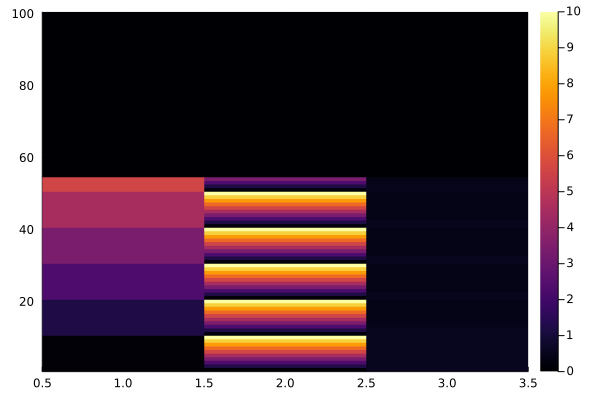

Progress:  92%|██████████████████████████████████████   |  ETA: 0:00:19                                                                        1:20

In [28]:
heatmap(heatmap_values)

In [29]:
CSV.write("file.csv", heatmap_values)

LoadError: [91mArgumentError: a 'Array{Float64,2}' is not a table; see `?Tables.table` for ways to treat an AbstractVecOrMat as a table[39m

In [30]:
heatmap_values

100×3 Array{Float64,2}:
 0.1            0.1           0.522673
 0.1            1.2           0.521389
 0.1            2.3           0.521088
 0.1            3.4           0.520629
 0.1            4.5           0.520155
 0.1            5.6           0.519622
 0.1            6.7           0.518923
 0.1            7.8           0.518202
 0.1            8.9           0.51756
 0.1           10.0           0.516961
 1.2            0.1           0.526468
 1.2            1.2           0.5234
 1.2            2.3           0.431146
 ⋮                            
 0.0            2.45249e-315  0.0
 0.0            0.0           0.0
 7.68547e-316   0.0           8.77305e-316
 0.0            0.0           1.265e-321
 0.0            8.79003e-316  0.0
 0.0            1.39804e-76   7.68547e-316
 8.77305e-316   0.0           0.0
 6.0264e-315    1.43867e-314  0.0
 0.0            0.0           0.0
 1.43867e-314   0.0           8.77305e-316
 0.0            0.0           6.0264e-315
 0.0            8.7901e-3

In [31]:
section = PoincareSection(Parameters(1.,1.), energy(Parameters(1.,1.), State(0.,0.,0.,1.)))
dim = correlationdimension(section)

LoadError: [91mDomainError with 1.25:[39m
[91macos(x) not defined for |x| > 1[39m

# Sandbox

In [84]:
@time energy_section(p, -1.)

  0.000110 seconds (4 allocations: 64.156 KiB)


1024-element StateVector:
 [0.0, 0.0, 0.0, 3.4641016151377544]
 [0.0, 0.0, 0.0, -3.4641016151377544]
 [0.0, 0.0, 0.2857883832488647, 2.748046706126839]
 [0.0, 0.0, 0.2857883832488647, -3.891200239122298]
 [0.0, 0.0, 0.5715767664977294, 1.6993101870896365]
 [0.0, 0.0, 0.5715767664977294, -3.985617253080554]
 [0.0, 0.0, 0.8573651497465942, 0.06827278519286994]
 [0.0, 0.0, 0.8573651497465942, -3.4977333841792464]
 [0.0, 0.4487989505128276, 0.0, 3.4064461644960238]
 [0.0, 0.4487989505128276, 0.0, -3.4064461644960238]
 [0.0, 0.4487989505128276, 0.281031808570922, 2.748848743553096]
 [0.0, 0.4487989505128276, 0.281031808570922, -3.761652385203948]
 [0.0, 0.4487989505128276, 0.562063617141844, 1.7394678806953223]
 ⋮
 [0.7227342478134157, 1.332932883023098, 0.16018662539423478, 0.5126122286780034]
 [0.7227342478134157, 1.332932883023098, 0.16018662539423478, -1.037725906676178]
 [0.7227342478134157, 1.332932883023098, 0.2402799380913522, 0.02313248786912178]
 [0.7227342478134157, 1.33293288302

In [39]:
n += 1

2

In [37]:
n

1

In [45]:
state1 = State(1., 2., 3., 4.)
state2 = State(15., 16., 17., 18.)

4-element State:
 15.0
 16.0
 17.0
 18.0

In [46]:
state2-state1

4-element State:
 14.0
 14.0
 14.0
 14.0

In [48]:
(state2-state1).θ2

14.0

In [49]:
size(section2)

(165810,)

In [1]:
3::Float64

3

In [28]:
Float64 <: Float64

true